## This script demonstrates how to use `polaris.curation` module to perform the data curation
- DMPK datasets published in in Fang et al. 2023 (DOI:10.1021/acs.jcim.3c00160). 

- Curate the chemistry information on the molecules.
  - Clean the molecules by perform molecule fix and sanitization,  standardization molecules, salts/solvents removals.
  - Remove stereochemistry information if `ignore_stereo` is set to `True`. This is recommended if the downstream molecule representation is not able to differentiate the stereoisomers. 

- Curate the measured endpoint values in the datasets
  - Merge measurements of repeated molecules in the dataset. The identification of the repeated molecules is defined by `dm.hash_mol` with or without stereochemistry information.
  - Classify the measured values based on provided threshold values for classification tasks.
  - Detect activity cliff between the stereoisomers. When `mask_stereo_cliff` is set to true, the targeted activity values of those molecules pairs will be set to `None`. This is recommended if the downstream molecule representation is not able to differentiate the stereoisomers.


In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm 
from polaris import curation

### Data curation for DMPK datasets

In [2]:
INDIR = "gs://polaris-private/dataset/DMPK/Fang2023"
OUTDIR = "gs://polaris-private/dataset/DMPK"

In [3]:
# Define data column names
endpoints = {
             "HLM": ['LOG HLM_CLint (mL/min/kg)'], 
             "RLM": ['LOG RLM_CLint (mL/min/kg)'], 
             "hPPB": ['LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)'], 
             "rPPB": ['LOG PLASMA PROTEIN BINDING (RAT) (% unbound)'], 
             "MDR1_ER": ['LOG MDR1-MDCK ER (B-A/A-B)'], 
             "Sol": ['LOG SOLUBILITY PH 6.8 (ug/mL)']}

# Define thresholds for class conversions 
class_thresholds = {
                 "HLM": None, 
                 "RLM": None, 
                 "hPPB":  [{"threshold_values": [0.3, 1], "threshold_labels": [2, 1, 0] }], 
                 "rPPB": [{"threshold_values": [0.3, 1], "threshold_labels": [2, 1, 0] }], 
                 "MDR1_ER": [{"threshold_values": [ 1, 2], "threshold_labels": [0, 1, 2] }], 
                 "Sol": [{"threshold_values": [ 0, 1,], "threshold_labels": [0, 1, 2] }], 
}

### Perform curation without stereochemistry information.

In [4]:
for endpoint, data_cols in endpoints.items():
    print(endpoint, data_cols)
    data = dm.read_sdf(f"{INDIR}/ADME_{endpoint}.sdf", as_df=True)
    data["mol"] = dm.read_sdf(f"{INDIR}/ADME_{endpoint}.sdf")
    
    curator_without_stereo = curation.Curator(data=data, data_cols = data_cols, mol_col="mol", 
                          ignore_stereo=True, class_thresholds=class_thresholds[endpoint])
    df_without_stereo = curator_without_stereo.run()
    print(df_without_stereo.head(5))
    df_without_stereo.to_csv(f"{OUTDIR}/{endpoint}/without_stereo.csv", index=False)

HLM ['LOG HLM_CLint (mL/min/kg)']


/Users/lu.zhu/miniconda3/envs/polaris/lib/python3.11/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/lu.zhu/miniconda3/envs/polaris/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                       molhash_id_no_stereo  LOG HLM_CLint (mL/min/kg)  \
0  0016f2f527d2b501efc5f291b0c8fd0b6debf731                   2.272466   
1  003f48908cf65fdc5efe071860ccc8df45d5ac90                   0.707996   
2  0053bfaf061dd64ebe6f76de2083fbb9b17a12ac                   0.675687   
3  007f86b0c19715355e81ef57de5e3f24c390817f                   1.208549   
4  009b95d7053dc0d8d0c40127d6009e9a1d6db61d                   1.490239   

                                              smiles  
0  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...  
1             CN1CCc2nc(NC(=O)c3cncn3-c3ccccc3)sc2C1  
2           Cc1cc(C)n2nc(C)c(C(=O)NCCc3nnc(C)s3)c2n1  
3    CNCc1cc(NC)nc(C2CCCN2C(=O)C(C)(C)c2ccc(C)cc2)n1  
4                         CC(C)CNc1nnc(SCc2ccncc2)s1  
RLM ['LOG RLM_CLint (mL/min/kg)']
                       molhash_id_no_stereo  LOG RLM_CLint (mL/min/kg)  \
0  0016f2f527d2b501efc5f291b0c8fd0b6debf731                   3.284991   
1  003f48908cf65fdc5efe071860ccc8df45d5ac90

In [5]:
data.head(5)

,smiles,Vendor ID,SMILES,CollectionName,LOG SOLUBILITY PH 6.8 (ug/mL),Internal ID,mol,ori_mol,ori_LOG SOLUBILITY PH 6.8 (ug/mL)
0,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,0.089905,Mol1,<rdkit.Chem.rdchem.Mol object at 0x16a06e960>,<rdkit.Chem.rdchem.Mol object at 0x16a06e960>,0.089905
1,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,0.550228,Mol2,<rdkit.Chem.rdchem.Mol object at 0x16a06dd20>,<rdkit.Chem.rdchem.Mol object at 0x16a06dd20>,0.550228
2,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,1.657056,Mol4,<rdkit.Chem.rdchem.Mol object at 0x16a06cdd0>,<rdkit.Chem.rdchem.Mol object at 0x16a06cdd0>,1.657056
3,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,1.033424,Mol6,<rdkit.Chem.rdchem.Mol object at 0x16a06db60>,<rdkit.Chem.rdchem.Mol object at 0x16a06db60>,1.033424
4,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,0.933990,Mol9,<rdkit.Chem.rdchem.Mol object at 0x16a06c200>,<rdkit.Chem.rdchem.Mol object at 0x16a06c200>,0.933990


### Perform curation which takes stereochemistry information into account. 

It's important to detect and analyze the activity cliff between the stereoisomers.

In [6]:
data_stereo_dict = {}
for endpoint, data_cols in endpoints.items():
    print(endpoint, data_cols)
    data = dm.read_sdf(f"{INDIR}/ADME_{endpoint}.sdf", as_df=True)
    data["mol"] = dm.read_sdf(f"{INDIR}/ADME_{endpoint}.sdf")

    curator_with_stereo = curation.Curator(data=data, data_cols =data_cols, mol_col="mol", 
                         mask_stereo_cliff=False, ignore_stereo=False, class_thresholds=class_thresholds[endpoint])
    df_with_stereo = curator_with_stereo.run()
    print(df_with_stereo.head(5))
    df_with_stereo.to_csv(f"{OUTDIR}/{endpoint}/with_stereo.csv", index=False)
    data_stereo_dict[endpoint] = df_with_stereo 
    if class_thresholds[endpoint] is None:
        cliff_col = f'{data_cols[0]}_stereo_cliff'
    else:
        cliff_col = f'CLASS_{data_cols[0]}_stereo_cliff'
    print(df_with_stereo[cliff_col].value_counts())


HLM ['LOG HLM_CLint (mL/min/kg)']
                                 molhash_id  \
0  004682b6181fdc94e5f2baa08bdfedfcafc05b58   
1  0046e45908c12d223d08c7c4aed3dbce46ae3806   
2  005f1c27ec3c7326c64e1e549de6e8f015c9cd45   
3  0074442ec177a64ec7516fc5b31c6e858db9f77a   
4  00a5a3f30cd4f8c194af608991a22d244ac1c6d1   

                       molhash_id_no_stereo  LOG HLM_CLint (mL/min/kg)  \
0  a406786623387ef7ad1d9d9e8a7da46915b34f7b                   0.896416   
1  452656a01000b1083f009cd44934fdcdfa19ee3a                   1.366610   
2  04a8638967aef5ac15379013802586e4f183dd30                   1.469100   
3  0f3936c4bd9b07403fd0830c51d1b7ef733d4433                   0.675687   
4  992395b1709d662f2b380ea6ea2c6a443c8191f9                   1.204093   

  LOG HLM_CLint (mL/min/kg)_stereo_cliff  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                 

#### The stereoisomers which have activity cliff in the hPPB dataset.

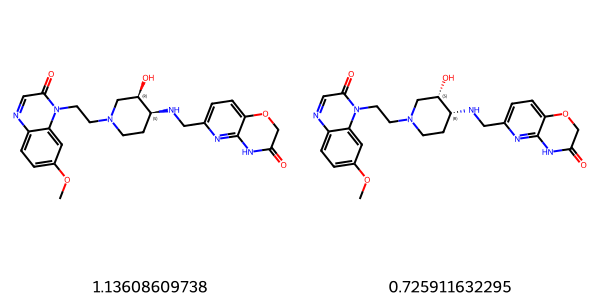

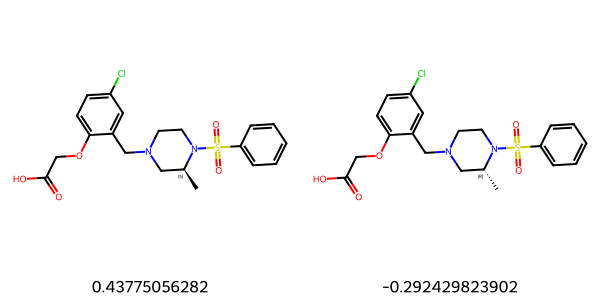

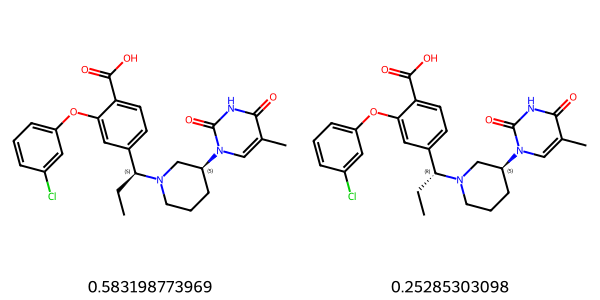

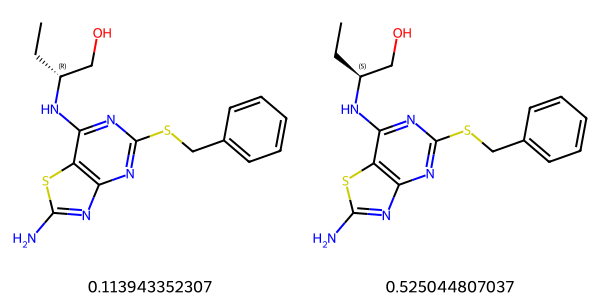

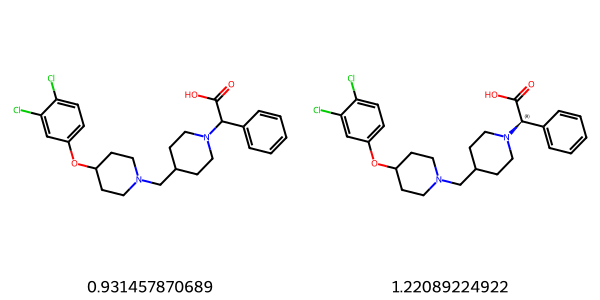

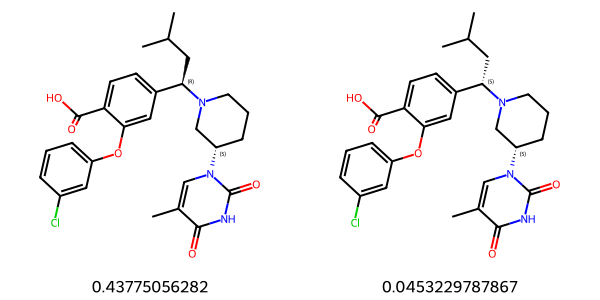

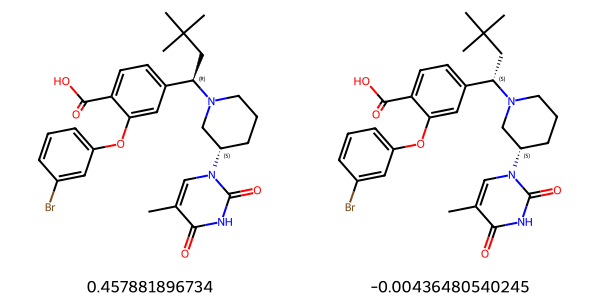

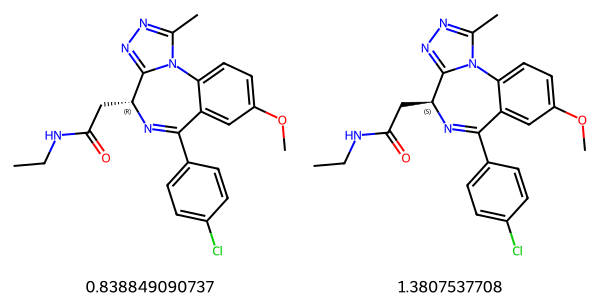

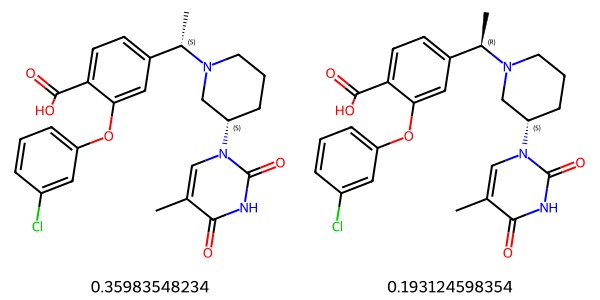

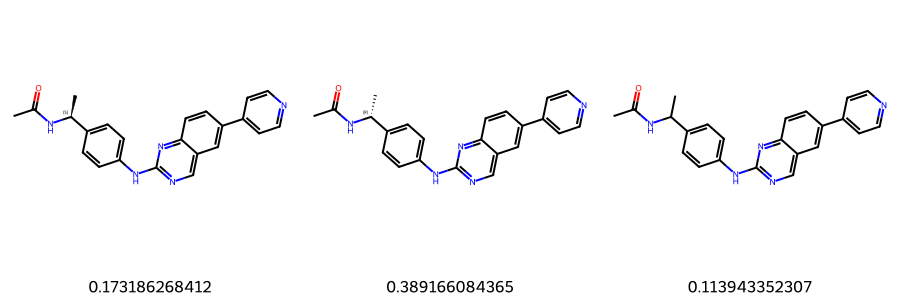

In [12]:
stereo_pair = data_stereo_dict['hPPB'].query("`CLASS_LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)_stereo_cliff` ==True")
for _, df in stereo_pair.groupby(by="molhash_id_no_stereo"):
    display(dm.to_image([dm.to_mol(mol) for mol in df.smiles], legends=df["LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)"].astype(str).tolist()))

The activity cliff analysis is important to understand SAR and make decision on which molecular representation to use or whether to remove some or all of the isomers from the training set. 
However, the stereocenter of the third molecule in the last group is not defined. The measured activity is from the mixture of different isomers. 
If the molecular representation is able to identify the stererochemistry, the third molecule is recommended to be removed. 